# Analyze study focus group data

#### General notes on coding style.
 - I do not follow the convention of importing libraries to abbreviations as it violates good programming practices, as well as Python's alleged purpose to produce code that is human legible.
 - I also eschew the use of Comprenehsions and Lambdas, because they introduce a very cryptic element worthy of lisp or C at its worst, again violating Python's stated aim of easy human readability. For this reason my code may run slower; I exchange speed for adherence to clear coding practices and *easy Human Readbility*
 

#### The next files to look at are the presentation and the if you're curious and have a working copy of Tableau, the Tableau notebook...though it is exceedingly simple

In [1]:
import pandas
import datetime
import matplotlib
import seaborn
import numpy
import sklearn

from sklearn import metrics
from sklearn.linear_model import LinearRegression

#turn off the really annoying deprecation messages
import warnings
warnings.filterwarnings('ignore')

#### Directories and filenames are declared at the top so changing them is a simple matter.

In [2]:
input_path = "./output data/"
input_violent_crime_by_city_and_state_with_geographical_location = "output_focus_group_and_incident"
state_population_projections_2010_to_2016 = "population predictions by state 2010-2016"

input_path = "./output data/"
final_dataset_name = "final_dataset"

#### load the crimes data

In [3]:
analysis_dataframe =pandas.DataFrame()
analysis_dataframe = pandas.read_csv(input_path+input_violent_crime_by_city_and_state_with_geographical_location+".csv")

In [4]:
analysis_dataframe.head()

,bias,center_lat,center_long,city,city_population,northeast_lat,northeast_long,southwest_lat,southwest_long,state,year
0,Anti-Female Homosexual,32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
1,"Anti-Lesbian, Gay, Bisexual, or Transgender, M...",32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
2,"Anti-Lesbian, Gay, Bisexual, or Transgender, M...",32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
3,Anti-Male Homosexual,32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
4,Anti-Male Homosexual,32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0


In [5]:
analysis_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43012 entries, 0 to 43011
Data columns (total 11 columns):
bias               43012 non-null object
center_lat         43012 non-null float64
center_long        43012 non-null float64
city               43012 non-null object
city_population    43012 non-null float64
northeast_lat      43012 non-null float64
northeast_long     43012 non-null float64
southwest_lat      43012 non-null float64
southwest_long     43012 non-null float64
state              43012 non-null object
year               43012 non-null float64
dtypes: float64(8), object(3)
memory usage: 3.6+ MB


## population growth vs hate crimes over time

#### Load custom function library includes many functions to facilitate linear regression analysis and calculation of related metrics.

## NOTE : The following function definitions are from a large, custom,  general purpose function library. IT IS LONG !!!

#### my apologies for the length. I have tried to import it as an external .py file so it would not have to be included here but while python does load it, it refuses to recognize the functions, either as the typical <library name>.<function name>  or simply <function name>

In [6]:
def clean_numerics( target_string ):
    #convert a number possibly containing characters that Python can't inherently convert ($,% etc)
    #   into a float if it contains a decimal point or 'e' (in the correct place), otherwise an integer
    
    if type( target_string ) != str:
        raise TypeError
    
    #string_length = range(0,len(target_string)) #I think this line is obsolete and should be removed
    working_copy = target_string
    for current_character in target_string :
            if current_character in ( '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '.', '-', '+', 'e' ) :
                if (current_character=='.') | (current_character=='e') :
                    return_type = 'float'
            else :
                working_copy = working_copy.replace( current_character, '' )            
    
    if ('.' in working_copy) | ('e' in working_copy) :
        try :
            return float( working_copy )
        except :
            raise ValueError
    
    try :
        return int( working_copy )
    except :
        raise ValueError
     
    #not sure how we'd get here, but if we do, don't wipe out the original value if the var is saved back to itself.
    return target_string


def convert_percent_with_symbol_to_int( percent_string_value):
    if type( percent_string_value ) != str:
        raise TypeError
        
    return int(percent_string_value.replace( '%', '' ))


def convert_percent_series_from_string_to_int( dataframe, percent_string_value ):
    if type( Type( dataframe) ) != pandas.core.frame.DataFrame:
        raise TypeError
        
    if type( percent_string_value ) != str:
        raise TypeError
    
    dataframe[ target_fieldname ] = dataframe[ target_fieldname ].map( convert_percent_with_symbol_to_int )
    dataframe[ target_fieldname ].astype(int)
    
    return dataframe


def show_characteristics( dataframe ) :
    if type( dataframe) != pandas.core.frame.DataFrame :
        raise TypeError    
    
    print( "Data shape : ", dataframe.shape )
    print ( "\n\n")
    
    print ( "Descibe Data : \n", dataframe.describe() )
    print ( "\n\n")
    
    print( "Show info about Data : \n", dataframe.info() )
    print ( "\n\n" )

    print( "Summarize Data : \n", dataframe.head(3).T )
    print ( "\n\n" )
    
    print( "Features with NaNs & Count\n")
    for current_series in dataframe :
        if dataframe[current_series].isnull().sum() > 0 :
            print( current_series, " ", dataframe[current_series].isnull().sum() )
    print ( "\n\n" )
    
    
def find_errors_in_numeric_fields( dataframe, target_fieldname ) :
    if type( dataframe ) != pandas.core.frame.DataFrame:
        raise TypeError    
    
    if type( target_fieldname ) == str :
        raise TypeError
    
    erroneous_values = list()
    for current_value in dataframe[ target_fieldname ] :   
        try :
            float( current_value )
        except :
            erroneous_values.append ( current_value )
    return erroneous_values[:4]


def show_data_outside_boundaries( dataframe, target_fieldname , low, high ):
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError    
    
    if type( target_fieldname ) != str :
        raise TypeError
    
    if type( low ) != float and  type( low ) != int :
        raise TypeError
    
    if type( high ) != float and  type( high ) != int :
        raise TypeError  
    
    return dataframe[ (dataframe[ target_fieldname ] < low) & (dataframe[ target_fieldname ] > high ) ]

        
def get_linear_regression_model( independent_variables_dataframe ) :
    if type( independent_variables_dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError    

    #linear_regression_model.predict(independent_variables_dataframe )
    linear_regression_model.fit(independent_variables_dataframe)
    
    return linear_regression_model
 
    
def get_predictions_and_residuals( dataframe, linear_regression_model, list_of_features, dependent_variable_name )  :   
    
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError    

    if type( linear_regression_model ) != LinearRegression :
        raise TypeError 
    
    if type( list_of_features  ) !=  list :
        raise TypeError
        
    if type( dependent_variable_name ) !=  str :
        raise TypeError    
    
    independent_variables_dataframe = dataframe[ list_of_features ]
    dependent_variable_series = dataframe[ dependent_variable_name ]
    
    print( "type(independent_variables_dataframe) ==", type(independent_variables_dataframe) )
    
    predictions = linear_regression_model.predict( independent_variables_dataframe )
    residuals = dependent_variable_series  - predictions
    
    return predictions, residuals
    
    
def plot_scatter_plot_of_predictions_vs_residuals( predictions, residuals ) :
    if type( predictions ) !=  numpy.ndarray :
        raise TypeError 

    if type( residuals ) !=  pandas.core.series.Series :
        raise TypeError     
    
    print( "Scatter plot of predicitons vs residuals ")
    
    matplotlib.pyplot.scatter(predictions, residuals)
    matplotlib.pyplot.axhline( 0, color='red')
    matplotlib.pyplot.show()
    
    
def plot_coeficient_of_linear_regression_model( linear_regression_model ) :
    if type( linear_regression_model ) !=  sklearn.linear_model.base.LinearRegression :
        raise TypeError 

    print( "coeficient of linear regression model ")
    linear_regression_model.coef_
    matplotlib.pyplot.show()
    
    
def plot_intercept_of_regression_model( linear_regression_model ) :
    if type( linear_regression_model ) !=  sklearn.linear_model.base.LinearRegression :
        raise TypeError

    linear_regression_model.intercept_   #NOTE : intercept_  aka BIAS
    matplotlib.pyplot.show()

    
def plot_histogram_of_epsilon( dependent_variable_series, predictions ) :
    if type( dependent_variable_series ) !=  pandas.core.series.Series :
        raise TypeError    

    if type( predictions ) !=  numpy.ndarray :
        raise TypeError 
    
    residuals = dependent_variable_series  - predictions
    error_due_to_the_inherent_noisiness_of_the_universe = residuals.mean()  #this is epsilon, 
                                                                            #we want it as small as possible
    print( "epsilon = ", error_due_to_the_inherent_noisiness_of_the_universe )  
    residuals.hist()  #recall epsilon should be symmetrical; if histogram is symmetrical outliers are rare.
    matplotlib.pyplot.show()

def plot_scatter_of_hot_encoded_series( dataframe, series_prefix, xlabel="", ylabel="", title="" ) :
    
    
    
    if type( series_prefix ) !=  str :
        raise TypeError    
    
    if type( xlabel ) !=  str :
        raise TypeError 
        
    if type( ylabel ) !=  str :
        raise TypeError 
    
    if type( title ) !=  str :
        raise TypeError
        
    binary_fields = pandas.DataFrame({})
    
    for current_series in dataframe :
        if series_prefix in current_series :
            binary_fields[ current_series ] = [dataframe[current_series].sum(), 
                                               dataframe[ 
                                                   (dataframe[current_series]==1) & 
                                                   (dataframe[current_series]>0)][ 'SalePrice'].mean(),
                                               dataframe[ 
                                                   (dataframe[current_series]==1) & 
                                                   (dataframe[current_series]>0)][ 'SalePrice'].max(),
                                               dataframe[ 
                                                   (dataframe[current_series]==1) & 
                                                   (dataframe[current_series]>0)][ 'SalePrice'].min()
                                              ]
        
    features = binary_fields.T
    names = binary_fields.columns
    count = binary_fields.get_values()[0]
    average_cost = binary_fields.get_values()[1]/1000
    exp_value = binary_fields.get_values()[2]
    matplotlib.pyplot.scatter( count, names, alpha=0.2, s=average_cost, c="r" );
    matplotlib.pyplot.xlabel(xlabel)
    matplotlib.pyplot.ylabel(ylabel)
    matplotlib.pyplot.title( title )
    matplotlib.pyplot.colorbar()
    
    
def plot_histogram_of_dependent_variable( dataframe, dependent_variable_series ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    dependent_variable_series.hist() 
    matplotlib.pyplot.show()  

def subplot_dataset(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError       
    if type( list_of_titles ) !=  list :
        raise TypeError    
    if type( list_of_xlabels ) !=  list :
        raise TypeError    
    if type( list_of_ylabels ) !=  list :
        raise TypeError    
    
    nrows = int(numpy.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig,ax = matplotlib.pyplot.subplots(nrows=10, ncols=2) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    matplotlib.pyplot.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        seaborn.countplot(dataframe[column], ax=ax[0])
        fig.show()
        
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels ):
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    nrows = int(numpy.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig,ax = matplotlib.pyplot.subplots(nrows=nrows, ncols=2) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    matplotlib.pyplot.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        #ax[i].hist(dataframe[column]) # feel free to add more settings
        ax[i].plot(dataframe[column]) # feel free to add more settings
        # Set titles, labels, etc here for each subplot
        ax[i].set_title(list_of_titles[i])     # Set titles, labels, etc here for each subplot         
        ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_ylabel(list_of_ylabels[i])
        ax[i].set_ylim((1,25))


def calculate_mean_absolute_error( residuals ) :
    if type( residuals ) !=  pandas.core.series.Series :
        raise TypeError 

    mean_absolute_error = numpy.abs(residuals).mean()
    print( "Mean Absolute Error (MAE) = ", mean_absolute_error, "   (lower is better)" ) #recall : residuals = error
    return mean_absolute_error


def calculate_residual_sum_of_squares( residuals ) :
    if type( residuals ) !=  pandas.core.series.Series :
        raise TypeError 

    residuals_squared = residuals**2
    residual_sum_of_squares = residuals_squared.sum()
    print( "Residual Sum of Squares ( RSS ) = ", residual_sum_of_squares, "   (lower is better)" )
    return residual_sum_of_squares


def calculate_mean_squared_error( residual_sum_of_squares, predictions ) :
    if type( residual_sum_of_squares ) !=  numpy.float64 :
        raise TypeError
    
    if type( predictions ) !=  numpy.ndarray :
        print( "predictions should be of type numpy.ndarray" )
        raise TypeError 

    mean_squared_error = residual_sum_of_squares/len(predictions)
    
    print( "Mean Squared Error (MSE) = ", mean_squared_error, "   (lower is better)" )
    
    return mean_squared_error   


def calculate_root_mean_squared_error ( residual_sum_of_squares, predictions) :
    if type( residual_sum_of_squares ) !=  numpy.float64 :
        raise TypeError
    
    if type( predictions ) !=  numpy.ndarray :
        raise TypeError 
    
    root_mean_squared_error  = numpy.sqrt(residual_sum_of_squares/ len(predictions) )
    print( "Root Mean Squared Error ( RMSE ) = ", root_mean_squared_error, "   (lower is better)" )
    return root_mean_squared_error


def get_null_prediction( dependent_variable_series ) :
    null_prediction = dependent_variable_series.mean()
    return null_prediction


def calculate_null_residuals( dependent_variable_series, null_prediction ) :
    null_residuals = dependent_variable_series - null_prediction
    return null_residuals


def calculate_null_residual_sum_of_squares( null_residuals ) :    
    null_residual_sum_of_squares = (null_residuals **2).sum()
    return calculate_null_residual_sum_of_squares


def calculate_and_plot_null_model_vs_your_model( dataframe, 
                                                linear_regression_model, 
                                                independent_variables_dataframe, 
                                                list_of_features, 
                                                dependent_variable_series ) :
    
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    if type( linear_regression_model ) != LinearRegression :
        raise TypeError 
        
    model_score = linear_regression_model.score( independent_variables_dataframe, dependent_variable_series  )
    print( "Model Score = ", model_score, "   (higher is better)" )
    return model_score


def variance_inflation_factor(dataframe, feature1_name, feature2_name ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    feature1_series = dataframe[ feature1_name ]
    feature2_series = dataframe[ feature2_name ]
    linear_regression_model = LinearRegression()
    linear_regression_model.fit( feature1_series, feature2_series )
    R2 = linear_regression_model.score( feature1_series , feature2_series  )
    variance_inflation_factor =  ( (1) / (1-R2) )
    return variance_inflation_factor


def calculate_regression_info( dataframe,  list_of_features, dependent_variable_name ):
#dataframe
#list_of_features           (independent variables to include in regression model)
#dependent_variable_name    (predicted by independent variables )


    #####
    #
    independent_variables_dataframe = dataframe[ list_of_features ]
    dependent_variable_series = dataframe[ dependent_variable_name ]
    linear_regression_model = LinearRegression()
    linear_regression_model.fit( independent_variables_dataframe, dependent_variable_series )
    #
    #####
    #linear_regression_model, independent_variables_dataframe, dependent_variable_series = fit_linear_regression_model( dataframe, independent_variables_dataframe, dependent_variable_series )
   
    linear_regression_model.coef_
    matplotlib.pyplot.show()
    
    linear_regression_model.intercept_   #NOTE : intercept_  aka BIAS
    matplotlib.pyplot.show()

    predictions = linear_regression_model.predict(independent_variables_dataframe )

    residuals = dependent_variable_series  - predictions
    error_due_to_the_inherent_noisiness_of_the_universe = residuals.mean()  #this is epsilon, we want it as small as possible
    print( "epsilon = ", error_due_to_the_inherent_noisiness_of_the_universe )  
    residuals.hist()  #recall epsilon should be symmetrical; if histogram is symmetrical outliers are rare.
    matplotlib.pyplot.show()
    
    print( "Histogram of dependent variable (", dependent_variable_name, ")")
    dependent_variable_series.hist() 
    matplotlib.pyplot.show()
        
    print( "Scatter plot of predicitons vs residuals ")
    matplotlib.pyplot.scatter(predictions, residuals)
    matplotlib.pyplot.axhline( 0, color='red')
    matplotlib.pyplot.show()
        
    mean_absolute_error = numpy.abs(residuals).mean()
    print( "Mean Absolute Error = ", mean_absolute_error, "   (lower is better)" ) #recall : residuals = error
    
    #this isn't a standard way of statistical analysis necessarily, but it seems useful for finding outliers
    residuals_squared = residuals**2
    residual_sum_of_squares = residuals_squared.sum()
    print( "Residual Sum of Squares = ", residual_sum_of_squares, "   (lower is better)" )
    
    mean_squared_error = residual_sum_of_squares/len(predictions)
    print( "Mean Squared Error = ", mean_squared_error, "   (lower is better)" )  
 
    root_mean_squared_error = numpy.sqrt( (residual_sum_of_squares/ len(predictions) ))
    print( "Root Mean Squared Error = ", root_mean_squared_error, "   (lower is better)" )  
  
    null_prediction = dependent_variable_series.mean()
    print( "Null Prediction = ", null_prediction )

    null_residuals = dependent_variable_series - null_prediction
        
    null_rss = (null_residuals **2).sum()
    print( "Null RSS= ", null_rss )

    #R**2
    # R**2 == 0; your model is no better than the null model; negative is WORSE than the null model
    # R**2 == 1; perfect model; (no such thing but you want it as close as possible )
    model_score = linear_regression_model.score( independent_variables_dataframe , dependent_variable_series  )
    print( "Model Score = ", model_score, "   (higher is better)" ) 
   
    #correlate if multiple independent variables
    if len(list_of_features) > 1 :
        heatmap_feature_list = list_of_features
        heatmap_feature_list.extend( [ dependent_variable_name ] )
        
        heatmap_feature_dataframe = dataframe[ heatmap_feature_list ]
        print( heatmap_feature_dataframe.head() ) 
        seaborn.heatmap( heatmap_feature_dataframe.corr()[[dependent_variable_name]].sort_values(dependent_variable_name), annot=True, cmap='coolwarm' )
    
    return linear_regression_model
    
    
def calculate_regression_for_interaction_terms( dataframe,  
                                              list_of_features, 
                                              interaction_fieldname, 
                                              dependent_variable_series ) :
    
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    if type( list_of_features  ) !=  list :
        raise TypeError

    independent_variables_dataframe = dataframe[ list_of_features ]    
    for current_feature in list_of_features :
        try :
            if independent_variables_dataframe[interaction_fieldname] :
                independent_variables_dataframe[ interaction_fieldname ] = independent_variables_dataframe[ interaction_fieldname ] * dataframe[ current_feature ]
        except :        
            independent_variables_dataframe[interaction_fieldname] = dataframe[ current_feature ]
   
    return perform_linear_regression( dataframe, list_of_features, dependent_variable_name )


def perform_linear_regression( dataframe, list_of_features, dependent_variable_name, plots=[] ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    if type( list_of_features  ) !=  list :
        raise TypeError

    if type( dependent_variable_name ) !=  str :
        raise TypeError
        
    independent_variables_dataframe = dataframe[ list_of_features ]
    dependent_variable_series = dataframe[ dependent_variable_name ]    
    linear_regression_model = calculate_regression_info( dataframe,  
                                                        list_of_features, 
                                                        dependent_variable_name )
#not trying to predict for this project
#    predictions, residuals = get_predictions_and_residuals( dataframe, 
#                                                          linear_regression_model, 
#                                                          list_of_features, 
#                                                          dependent_variable_name )
#    calculate_mean_absolute_error( residuals )
#    residual_sum_of_squares = calculate_residual_sum_of_squares( residuals )
#    mean_squared_error = calculate_mean_squared_error( residual_sum_of_squares, predictions )
#    root_mean_squared_error = calculate_root_mean_squared_error( residual_sum_of_squares, predictions)
#    null_prediction_array = get_null_prediction( independent_variables_dataframe )
#    null_residuals = calculate_null_residuals( independent_variables_dataframe, null_prediction_array )
#    null_residual_sum_of_squares = calculate_null_residual_sum_of_squares( null_residuals )
    
    
    R_squared = calculate_and_plot_null_model_vs_your_model( dataframe, 
                                                            linear_regression_model, 
                                                            independent_variables_dataframe, 
                                                            list_of_features, 
                                                            dependent_variable_series )

    if "coeficient" in plots :
        plot_coeficient_of_linear_regression_model( linear_regression_model )
        

    if "intercept" in plots :
        plot_intercept_of_regression_model( linear_regression_model )

        
    if "epsilon" in plots :
        plot_histogram_of_epsilon( dependent_variable_series, predictions )
    
     
    if "histogram" in plots :
        plot_histogram_of_dependent_variable( dataframe, independent_variables_dataframe )
        
     
    if "predictions" in plots :
        plot_scatter_plot_of_predictions_vs_residuals( predictions, residuals )
    
     
    if "regression" in plots :
        for series_name in list_of_features :
            seaborn.regplot(x=dependent_variable_name, y=series_name, data=dataframe );
            matplotlib.pyplot.show()        
       
    return linear_regression_model
    
    
def minimize_sse( dataframe, predictor_list, target_list ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    y = dataframe[ target_list ]
    X = dataframe[ predictor_list ]
    
    # Calculate the five "ingredients."
    y_bar = y.mean()
    x_bar = X.mean()
    std_y = y.std()
    std_x = X.std()
    r_xy = dataframe.corr().loc[ predictor_list, target_list ]

    # Calculate the betas.
    beta_1 = r_xy * std_y / std_x
    beta_0 = y_bar - beta_1 * x_bar

    yhat_linear = beta_0 + beta_1*X
    matplotlib.pyplot.scatter( X, y )
    matplotlib.pyplot.plot(X, yhat_linear, color='k');
    matplotlib.pyplot.show()
    
    return beta_0, beta_1


def hot_encode( dataframe, dictionary ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    if type( dictionary ) != dict :
        raise TypeError
    
    for current_series_name in dictionary :
        try :
            dataframe = pandas.concat([dataframe, pandas.get_dummies(dataframe[current_series_name], prefix=dictionary[current_series_name] ) ], axis=1)
        except :
            print( "Something's wrong with the ", current_series_name, " series.")
            pass
    
    return dataframe

    
def get_train_and_test_metrics(dataframe, list_of_features, dependent_variable_name ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    features =[ c for c in dataframe._get_numeric_data().columns if not c in [dependent_variable_name]]
    X = dataframe[ features ] #all series except the independent variable
    y = dataframe[ dependent_variable_name ]

    X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42)

    return X, y, X_train, X_test, y_train, y_test


def compare_train_to_test( dataframe, model, list_of_features, dependent_variable_name  ) :
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    X, y, X_train, X_test, y_train, y_test = get_train_and_test_metrics(dataframe, list_of_features, dependent_variable_name )
    predict, residual = get_predictions_and_residuals( dataframe, model, X , y )
    return predict, residual
    
    
def get_features_matrix_and_target_vector( dataframe, 
                                          linear_regression_model, 
                                          independent_variable_list, 
                                          dependent_variable_name ) :
    
    if type( dataframe ) != pandas.core.frame.DataFrame :
        raise TypeError
          
    if type( linear_regression_model ) !=  LinearRegression :
        raise TypeError 

    if type( independent_variable_list ) !=  list :
        raise TypeError    

    if type( dependent_variable_name ) !=  str :
        raise TypeError    

    features =[ c for c in dataframe._get_numeric_data().columns if not c in [dependent_variable_name]]
    X = dataframe[ independent_variable_list ] #all series except the independent variable
    y = dataframe[ dependent_variable_name ]
    X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42)
    
    linear_regression_model.score( X_train, y_train)
    linear_regression_model.score( X_test, y_test)

    predict, residual = get_predictions_and_residuals( dataframe, linear_regression_model,
                                                      independent_variable_list,
                                                      dependent_variable_name )

    return predict, residual
    

In [7]:
analysis_dataframe.head()

,bias,center_lat,center_long,city,city_population,northeast_lat,northeast_long,southwest_lat,southwest_long,state,year
0,Anti-Female Homosexual,32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
1,"Anti-Lesbian, Gay, Bisexual, or Transgender, M...",32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
2,"Anti-Lesbian, Gay, Bisexual, or Transgender, M...",32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
3,Anti-Male Homosexual,32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0
4,Anti-Male Homosexual,32.222607,-110.974711,TUCSON,517607.0,32.320166,-110.708204,31.991654,-111.059406,AZ,2002.0


In [8]:
analysis_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43012 entries, 0 to 43011
Data columns (total 11 columns):
bias               43012 non-null object
center_lat         43012 non-null float64
center_long        43012 non-null float64
city               43012 non-null object
city_population    43012 non-null float64
northeast_lat      43012 non-null float64
northeast_long     43012 non-null float64
southwest_lat      43012 non-null float64
southwest_long     43012 non-null float64
state              43012 non-null object
year               43012 non-null float64
dtypes: float64(8), object(3)
memory usage: 3.6+ MB


#### Accumulate data in proper hierarchies in a dictionary so that it can added to a DataFrame as Year, State, City, <data>

In [9]:
crimes_by_location_population_by_year = dict()

iterations = 0
for iterations in range( 0 , analysis_dataframe.shape[0], 1) :

    population = analysis_dataframe.iloc[iterations, 4]
    if population==0 :
        continue

    year = analysis_dataframe.iloc[iterations, 10]
    city = analysis_dataframe.iloc[iterations, 3]
    state = analysis_dataframe.iloc[iterations, 9]
    northeast_lat = analysis_dataframe.iloc[iterations, 5]
    northeast_long = analysis_dataframe.iloc[iterations, 6]
    southwest_lat = analysis_dataframe.iloc[iterations, 7]
    southwest_long = analysis_dataframe.iloc[iterations, 8]
    
    if (iterations>0) & (iterations%100 == 0 ):
        print( iterations )
    iterations += 1  
       
    try :
        rec=crimes_by_location_population_by_year[year]
    except :
        crimes_by_location_population_by_year.update( { year : 
                                                           { state : 
                                                                { city : {
                                                                        'population' : population,
                                                                        'crimes' : 0,
                                                                        'northeast_lat' : northeast_lat,
                                                                        'northeast_long' : northeast_long,
                                                                        'southwest_lat' : southwest_lat,
                                                                        'southwest_long' : southwest_long
                                                                    }
                                                                },
                                                           }
                                                      } )

    try :
        rec=crimes_by_location_population_by_year[year][state]
    except :
        crimes_by_location_population_by_year[year].update( { state : 
                                                                { city : {
                                                                        'population' : population,
                                                                        'crimes' : 0,
                                                                        'northeast_lat' : northeast_lat,
                                                                        'northeast_long' : northeast_long,
                                                                        'southwest_lat' : southwest_lat,
                                                                        'southwest_long' : southwest_long
                                                                    },
                                                                },
                                                           } )

    try :
        rec=crimes_by_location_population_by_year[year][state][city]
    except :
        crimes_by_location_population_by_year[year][state].update(  { city : 
                                                                            {
                                                                                'population' : population,
                                                                                'crimes' : 0,
                                                                                'northeast_lat' : northeast_lat,
                                                                                'northeast_long' : northeast_long,
                                                                                'southwest_lat' : southwest_lat,
                                                                                'southwest_long' : southwest_long
                                                                            }
                                                                    }
                                                                 )
        

    crime_count_by_location = crimes_by_location_population_by_year[year][state][city]['crimes']
    crimes_by_location_population_by_year[year][state][city]['crimes'] = crime_count_by_location + 1

100
200
300
400
500
700
800
900
1200
1300
1400
1500
1600
1700
1800
1900
2100
2200
2300
2400
2500
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8500
8600
8700
8800
9000
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10400
10500
10600
10700
10800
10900
11000
11100
11200
11400
11500
11600
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12900
13000
13100
13300
13400
13500
13600
13700
13800
13900
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900
20000

In [10]:
crimes_by_location_population_by_year

{2002.0: {'AZ': {'TUCSON': {'population': 517607.0,
    'crimes': 24,
    'northeast_lat': 32.320166100000002,
    'northeast_long': -110.70820399999999,
    'southwest_lat': 31.991653899999999,
    'southwest_long': -111.059406},
   'COTTONWOOD': {'population': 9761.0,
    'crimes': 2,
    'northeast_lat': 34.765031999999998,
    'northeast_long': -111.94878110000001,
    'southwest_lat': 34.649546899999997,
    'southwest_long': -112.0529471},
   'YUMA': {'population': 61784.0,
    'crimes': 4,
    'northeast_lat': 32.732294000000003,
    'northeast_long': -114.45913,
    'southwest_lat': 32.479066899999999,
    'southwest_long': -114.68498599999999},
   'BISBEE': {'population': 6476.0,
    'crimes': 1,
    'northeast_lat': 31.462218,
    'northeast_long': -109.8674551,
    'southwest_lat': 31.377623,
    'southwest_long': -109.953309},
   'CHANDLER': {'population': 187795.0,
    'crimes': 4,
    'northeast_lat': 33.361857100000002,
    'northeast_long': -111.755287,
    'southwest_l

In [11]:
print( crimes_by_location_population_by_year[year].keys() )

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MT', 'NB', 'NC', 'ND', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV'])


In [12]:
# a little extra visual verification never hurts
print( crimes_by_location_population_by_year[1996.0] )

{'AK': {'ANCHORAGE': {'population': 254774.0, 'crimes': 4, 'northeast_lat': 61.483937900000001, 'northeast_long': -148.46000690000002, 'southwest_lat': 60.733790999999997, 'southwest_long': -150.4206149}}, 'AZ': {'BISBEE': {'population': 7251.0, 'crimes': 2, 'northeast_lat': 31.462218, 'northeast_long': -109.8674551, 'southwest_lat': 31.377623, 'southwest_long': -109.953309}, 'MESA': {'population': 340818.0, 'crimes': 4, 'northeast_lat': 33.513376000000001, 'northeast_long': -111.580636, 'southwest_lat': 33.277623900000002, 'southwest_long': -111.894881}, 'PHOENIX': {'population': 1139793.0, 'crimes': 48, 'northeast_lat': 33.920569999999998, 'northeast_long': -111.926046, 'southwest_lat': 33.290259800000001, 'southwest_long': -112.324056}, 'SCOTTSDALE': {'population': 165644.0, 'crimes': 4, 'northeast_lat': 33.900393000000001, 'northeast_long': -111.756092, 'southwest_lat': 33.448028999999998, 'southwest_long': -111.9608161}, 'TEMPE': {'population': 156788.0, 'crimes': 6, 'northeast_la

#This code prepares the way for a second level of analysis which will be added in a future version

crimes_by_state_population_by_year_dataframe = pandas.DataFrame()
crimes_by_state_population_by_year_dataframe = pandas.read_csv(input_path+state_population_projections_2010_to_2016+".csv", sep="\t")

crimes_by_state_population_by_year_dataframe['crimes2010'] = 0
crimes_by_state_population_by_year_dataframe['crimes2011'] = 0
crimes_by_state_population_by_year_dataframe['crimes2012'] = 0
crimes_by_state_population_by_year_dataframe['crimes2013'] = 0
crimes_by_state_population_by_year_dataframe['crimes2014'] = 0
crimes_by_state_population_by_year_dataframe['crimes2015'] = 0
crimes_by_state_population_by_year_dataframe['crimes2016'] = 0

crimes_by_state_population_by_year_dataframe.info()

In [13]:
#convert from hierarchical dictionary to what essentially amounst as a merged relational
#    database. It is possible that I could have accomplised all this more easily with 
#    the DataFrame,merge function or something similar...but I couldn't get it right at 
#    the time this code was developed....so that's something else to check in a future version

crimes_by_location_population_by_year_dataframe = pandas.DataFrame()

for year in crimes_by_location_population_by_year.keys() :
    for state in crimes_by_location_population_by_year[year].keys() :
        crimes_by_state = 0
        for city in crimes_by_location_population_by_year[year][state].keys() :
            #accumulate values by year/state/city
            city_single_row_dictionary = { 
                "year" : year, 
                "state" : state, 
                "city" : city,
                "population" : crimes_by_location_population_by_year[year][state][city]["population"], 
                "crimes" : crimes_by_location_population_by_year[year][state][city]["crimes"],
                "per-capita_crime" : crimes_by_location_population_by_year[year][state][city]["crimes"]/crimes_by_location_population_by_year[year][state][city]["population"],
                "northeast_lat" : crimes_by_location_population_by_year[year][state][city]["northeast_lat"], 
                "northeast_long" : crimes_by_location_population_by_year[year][state][city]["northeast_long"], 
                "southwest_lat" : crimes_by_location_population_by_year[year][state][city]["southwest_lat"], 
                "southwest_long" : crimes_by_location_population_by_year[year][state][city]["southwest_long"],
                "engineered_location" :  crimes_by_location_population_by_year[year][state][city]["northeast_lat"] *
                    crimes_by_location_population_by_year[year][state][city]["northeast_long"] *
                    crimes_by_location_population_by_year[year][state][city]["southwest_lat"] *
                    crimes_by_location_population_by_year[year][state][city]["southwest_long"]
            }
            crimes_by_location_population_by_year_dataframe = crimes_by_location_population_by_year_dataframe.append( city_single_row_dictionary,  ignore_index=True )


In [14]:
crimes_by_location_population_by_year_dataframe.head()

,city,crimes,engineered_location,northeast_lat,northeast_long,per-capita_crime,population,southwest_lat,southwest_long,state,year
0,TUCSON,24.0,1.271292e+07,32.320166,-110.708204,0.000046,517607.0,31.991654,-111.059406,AZ,2002.0
1,COTTONWOOD,2.0,1.511064e+07,34.765032,-111.948781,0.000205,9761.0,34.649547,-112.052947,AZ,2002.0
2,YUMA,4.0,1.395523e+07,32.732294,-114.459130,0.000065,61784.0,32.479067,-114.684986,AZ,2002.0
3,BISBEE,1.0,1.192578e+07,31.462218,-109.867455,0.000154,6476.0,31.377623,-109.953309,AZ,2002.0
4,CHANDLER,4.0,1.386171e+07,33.361857,-111.755287,0.000021,187795.0,33.203778,-111.972419,AZ,2002.0


#### save final dataframe to an output file.

In [15]:
crimes_by_location_population_by_year_dataframe.to_csv(input_path+final_dataset_name+".csv")

# Perform Analyses
#
### We will compare the statistical metrics and interpret graphs for a technical audience, but this will be included in the presentation AFTER the slides for the non-technical audience

#### perform linear regression to determine correlation of city population to number of crimes

epsilon =  -1.1505262370625807e-16


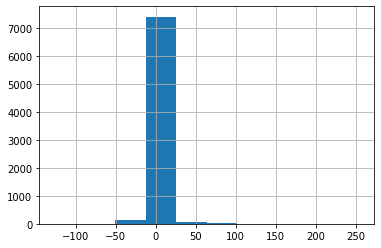

Histogram of dependent variable ( crimes )


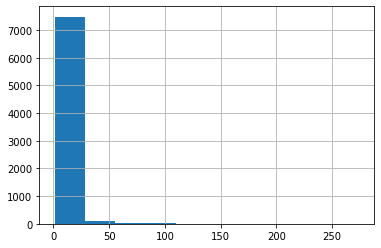

Scatter plot of predicitons vs residuals 


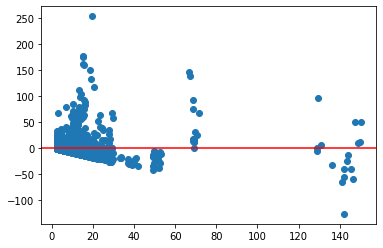

Mean Absolute Error =  3.3266464201872887    (lower is better)
Residual Sum of Squares =  746993.752493    (lower is better)
Mean Squared Error =  97.5442351126    (lower is better)
Root Mean Squared Error =  9.87644850706    (lower is better)
Null Prediction =  5.245364324889005
Null RSS=  1279643.96043
Model Score =  0.416248757006    (higher is better)
Model Score =  0.416248757006    (higher is better)
coeficient of linear regression model 


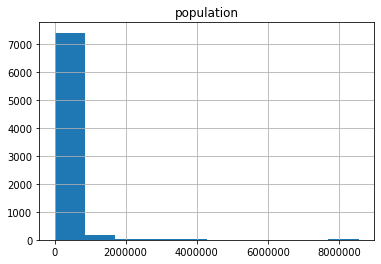

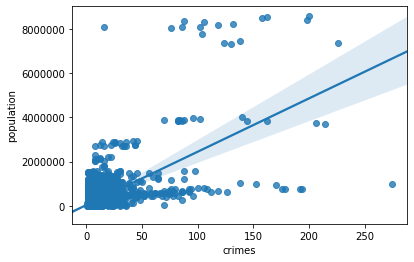

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
perform_linear_regression( crimes_by_location_population_by_year_dataframe, [ 'population' ],
                          'crimes', plots=["coeficient","intercept", "histogram","regression" ] )

#### perform linear regression to determine correlation of city population to number of crimes Per-Capita

epsilon =  -5.804686481053236e-21


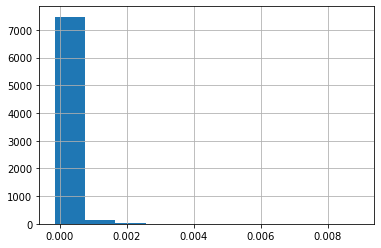

Histogram of dependent variable ( per-capita_crime )


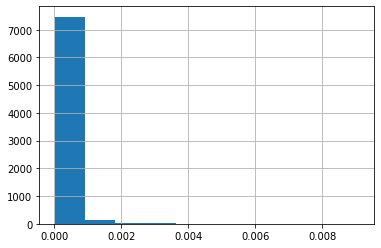

Scatter plot of predicitons vs residuals 


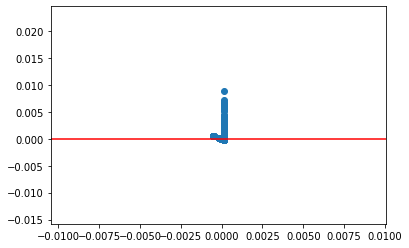

Mean Absolute Error =  0.0001545625441437315    (lower is better)
Residual Sum of Squares =  0.00101960335637    (lower is better)
Mean Squared Error =  1.33142250767e-07    (lower is better)
Root Mean Squared Error =  0.000364886627279    (lower is better)
Null Prediction =  0.00015357846429753748
Null RSS=  0.0010319640874
Model Score =  0.0119778693616    (higher is better)
Model Score =  0.0119778693616    (higher is better)
coeficient of linear regression model 


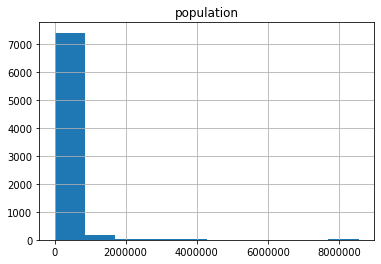

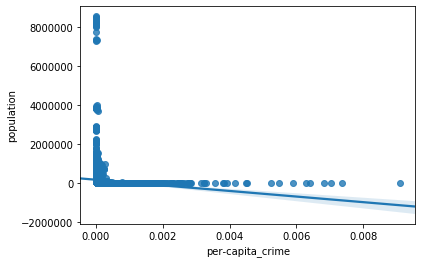

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
perform_linear_regression( crimes_by_location_population_by_year_dataframe, [ 'population' ],
                          'per-capita_crime', plots=["coeficient","intercept","histogram","regression" ] )

#### perform linear regression to determine correlation of location to number of crimes

epsilon =  -6.23077226040506e-14


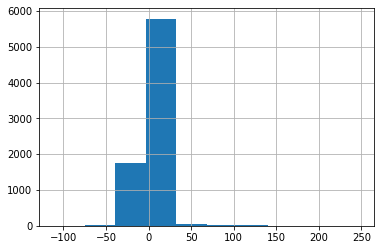

Histogram of dependent variable ( crimes )


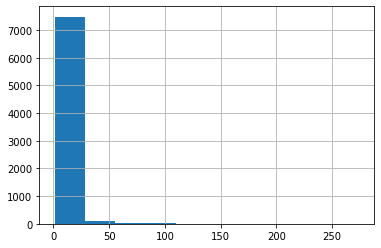

Scatter plot of predicitons vs residuals 


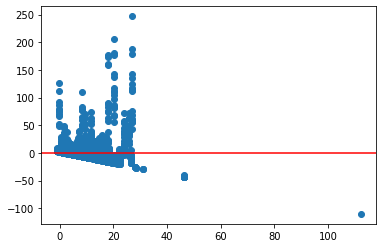

Mean Absolute Error =  4.2825731247295336    (lower is better)
Residual Sum of Squares =  1086628.53379    (lower is better)
Mean Squared Error =  141.894559127    (lower is better)
Root Mean Squared Error =  11.9119502655    (lower is better)
Null Prediction =  5.245364324889005
Null RSS=  1279643.96043
Model Score =  0.150835257782    (higher is better)
   northeast_lat  northeast_long  southwest_lat  southwest_long  crimes
0      32.320166     -110.708204      31.991654     -111.059406    24.0
1      34.765032     -111.948781      34.649547     -112.052947     2.0
2      32.732294     -114.459130      32.479067     -114.684986     4.0
3      31.462218     -109.867455      31.377623     -109.953309     1.0
4      33.361857     -111.755287      33.203778     -111.972419     4.0
Model Score =  0.150835257782    (higher is better)
coeficient of linear regression model 


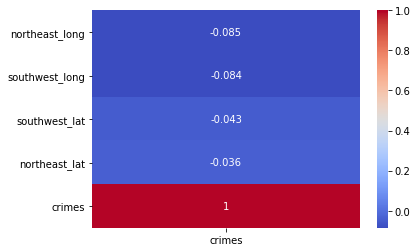

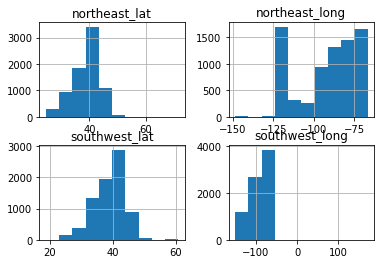

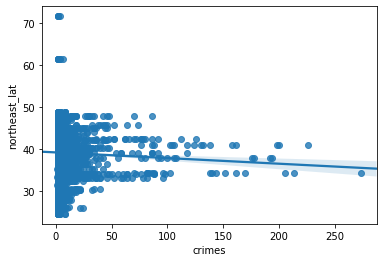

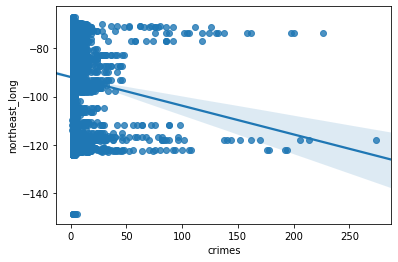

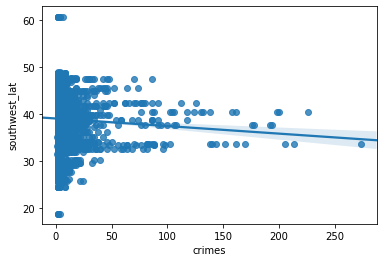

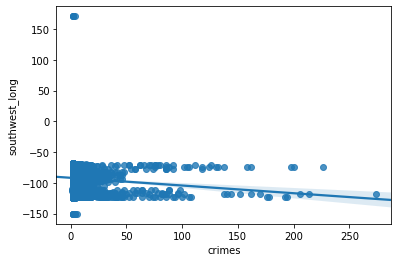

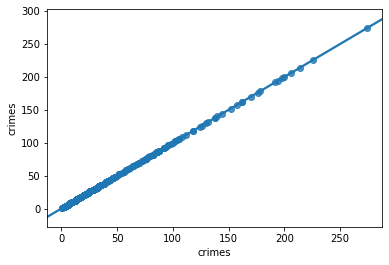

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
perform_linear_regression( crimes_by_location_population_by_year_dataframe, [ 'northeast_lat', 'northeast_long', 'southwest_lat', 'southwest_long' ],
                          'crimes', plots=["coeficient","intercept","histogram","regression" ] )

#### perform linear regression to determine correlation of location to number of crimes Per-Capita

epsilon =  4.07396611508257e-18


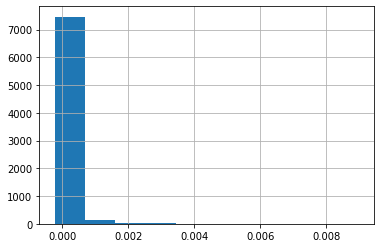

Histogram of dependent variable ( per-capita_crime )


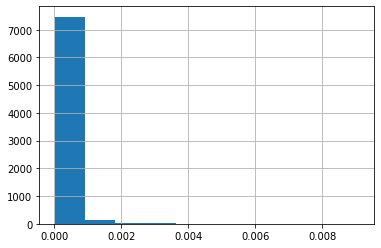

Scatter plot of predicitons vs residuals 


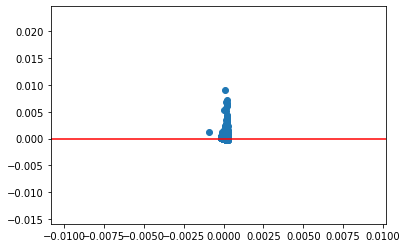

Mean Absolute Error =  0.00015013455172237895    (lower is better)
Residual Sum of Squares =  0.000995480587866    (lower is better)
Mean Squared Error =  1.29992241821e-07    (lower is better)
Root Mean Squared Error =  0.000360544368727    (lower is better)
Null Prediction =  0.00015357846429753748
Null RSS=  0.0010319640874
Model Score =  0.0353534584934    (higher is better)
   northeast_lat  northeast_long  southwest_lat  southwest_long  \
0      32.320166     -110.708204      31.991654     -111.059406   
1      34.765032     -111.948781      34.649547     -112.052947   
2      32.732294     -114.459130      32.479067     -114.684986   
3      31.462218     -109.867455      31.377623     -109.953309   
4      33.361857     -111.755287      33.203778     -111.972419   

   per-capita_crime  
0          0.000046  
1          0.000205  
2          0.000065  
3          0.000154  
4          0.000021  
Model Score =  0.0353534584934    (higher is better)
coeficient of linear regressio

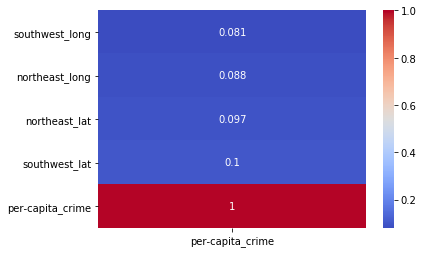

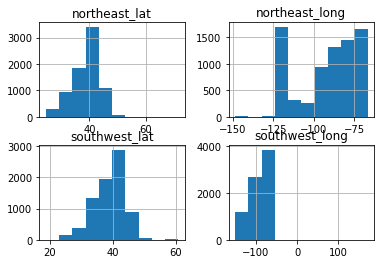

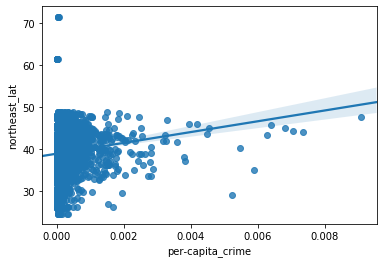

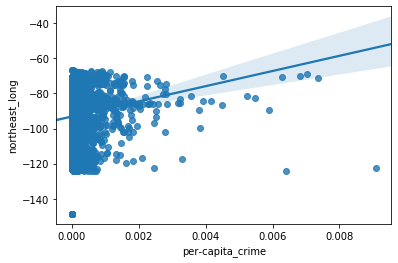

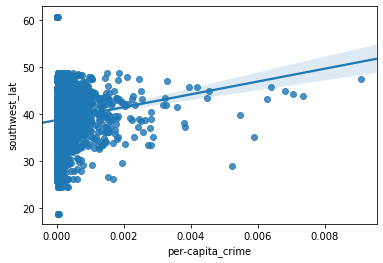

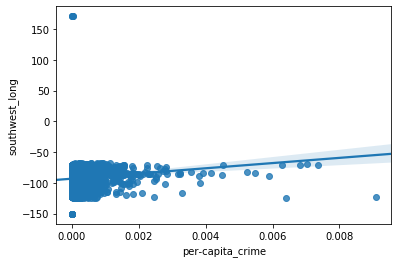

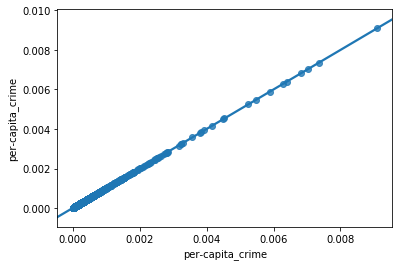

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
perform_linear_regression( crimes_by_location_population_by_year_dataframe, [ 'northeast_lat', 'northeast_long', 'southwest_lat', 'southwest_long' ],
                          'per-capita_crime', plots=["coeficient","intercept","histogram","regression" ] )

#### perform linear regression to determine correlation of engineered (synthetic) location to number of crimes Per-Capita

epsilon =  -1.1128008717336203e-20


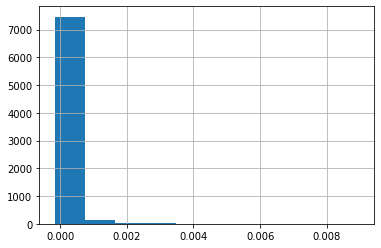

Histogram of dependent variable ( per-capita_crime )


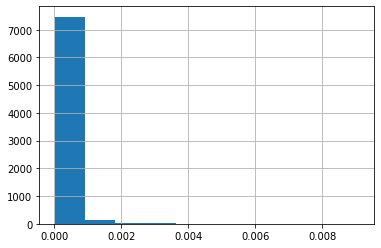

Scatter plot of predicitons vs residuals 


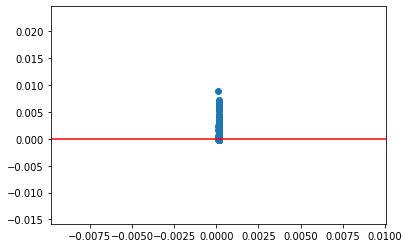

Mean Absolute Error =  0.00015606723959252274    (lower is better)
Residual Sum of Squares =  0.00103148243649    (lower is better)
Mean Squared Error =  1.34693449529e-07    (lower is better)
Root Mean Squared Error =  0.000367006061978    (lower is better)
Null Prediction =  0.00015357846429753748
Null RSS=  0.0010319640874
Model Score =  0.000466732236538    (higher is better)
Model Score =  0.000466732236538    (higher is better)
coeficient of linear regression model 


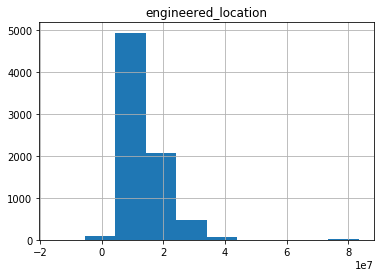

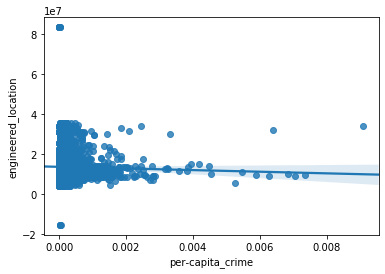

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
perform_linear_regression( crimes_by_location_population_by_year_dataframe, [ 'engineered_location' ],
                          'per-capita_crime', plots=["coeficient","intercept","histogram","regression" ] )